# Sampling Chemical Space for Drug Discovery using the MolMIM NIM

```{note}
This notebook assumes that you have the MolMIM NIM available at the following address: `http://localhost:8000`. If your container is available at different address, you will need to modify the URL below.
```

In the field of drug discovery, identifying novel and effective compounds is a crucial step in the development of new medicines. Chemical space, the vast expanse of all possible chemical compounds, is a complex landscape that can be difficult to navigate. Molecular generative AI models, such as MolMIM, can be used to sample this space and identify promising compounds.

## Unguided Sampling: Exploring Chemical Space around a Starting Seed Molecule

In this notebook, we will use MolMIM to perform unguided sampling around a starting seed molecule, upadacitinib. Unguided sampling involves generating new molecules without any specific goal or objective in mind. This can be useful for exploring new areas of chemical space and identifying novel compounds that may not have been considered before.

## Guided Optimization: Improving a Seed Molecule's QED Score

In addition to unguided sampling, we will also use MolMIM to perform guided optimization of the same seed molecule, upadacitinib. Guided optimization involves using a specific objective function, such as the Quantitative Estimate of Drug-likeness (QED) score, to guide the generation of new molecules. In this case, we will use the CMA-ES algorithm to optimize the QED score of upadacitinib.

## CMA-ES: A Global Optimization Algorithm

CMA-ES (Covariance Matrix Adaptation Evolution Strategy) is a global optimization algorithm that is well-suited for optimizing complex objective functions such as the QED score. It uses a population of candidate solutions to search for the optimal solution, and adapts the covariance matrix of the search distribution to improve the search process.

## Objectives

In this notebook, we will use MolMIM to:

1. Perform unguided sampling around the seed molecule upadacitinib to explore chemical space.
2. Perform guided optimization of upadacitinib using CMA-ES to improve its QED score.

## Random Sampling Around a Seed Molecule

In the code blocks below, we will step through how to randomly sample molecules in a similar chemical space to a seed molecule, in this case upadacitinib. We begin by importing the necessary libraries.

In [1]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')

This code block defines a function called `tanimoto_similarity` that calculates the Tanimoto similarity between two molecules. The function takes two parameters: `smiles`, the SMILES string of the molecule to be compared, and `reference`, the SMILES string of the reference molecule. The function first gets the fingerprint parameters, then creates the fingerprint for the reference molecule. It then validates the input molecule by converting its SMILES string to a molecule object and checks if the object is None. If the object is None, it returns 0. Otherwise, it creates the fingerprint for the input molecule and calculates the Tanimoto similarity between the two fingerprints. The function returns the calculated Tanimoto similarity.

In [2]:
def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    fingerprint_radius_param = 2
    fingerprint_nbits = 2048

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = GetMorganFingerprintAsBitVect(
        reference_mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits
    )

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)

This next block defines the molecule of interest, which is the SMILES string representation of the molecule upadacitinib. This molecule will be used as a reference for calculating Tanimoto similarity and QED scores for other molecules in the script.

In [3]:
# Define the molecule of interest
upadacitinib = 'CCC1CN(CC1C2=CN=C3N2C4=C(NC=C4)N=C3)C(=O)NCC(F)(F)F'

This code block defines the parameters for sampling radii and initializes lists and a dictionary to store the results of the sampling process. The `radii` variable is set to a numpy array of 10 evenly spaced values between 0.3 and 1.0, which will be used to sample different radii for the molecular fingerprint calculation. The `valid_smiles_counts`, `avg_tanimoto_similarities`, and `avg_qed_scores` lists will be used to store the number of valid SMILES strings, the average Tanimoto similarity, and the average QED score for each radius, respectively. The `results` dictionary will be used to store the results for each radius, with the radius as the key and a dictionary containing the results as the value.

In [4]:
# Define the radii to sample
radii = np.linspace(0.3, 1.0, num=10)

# Initialize lists to store the results
valid_smiles_counts = []
avg_tanimoto_similarities = []
avg_qed_scores = []

# Create a dictionary to store the results
results = {}

This code block is responsible for processing the results of the molecule sampling at different radii. It iterates over each radius, sends a request to the MolMIM sampling API, extracts the generated SMILES strings, filters out invalid ones, calculates the Tanimoto similarity and QED score for each valid SMILES string, and stores the results. After processing all radii, it creates a Pandas dataframe from the results.

In [5]:
# Loop through each radius
for radius in radii:
    # Create a dictionary to store the results for this radius
    radius_results = {'tanimoto_similarity': [], 'qed_score': []}
    
    # Create the request data
    data = {'sequences': [upadacitinib], 'num_molecules': 10, 'scaled_radius': radius}

    # Send the request and get the response
    headers = {'Content-Type': 'application/json'}
    response = requests.post('http://localhost:8000/sampling', headers=headers, json=data)

    # Parse the response as JSON
    response_json = json.loads(response.text)

    # Extract the generated SMILES strings
    generated_molecules = response_json['generated'][0]

    # Filter out invalid SMILES strings
    valid_smiles = [m for m in generated_molecules if Chem.MolFromSmiles(m) is not None]
    radius_results['valid_smiles'] = len(valid_smiles)
    
    # Calculate Tanimoto similarity and QED score for each valid SMILES string
    for smile in valid_smiles:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            tanimoto = tanimoto_similarity(smile, upadacitinib)
            qed_score = qed(mol)
            radius_results['tanimoto_similarity'].append(tanimoto)
            radius_results['qed_score'].append(qed_score)

    # Get the average of Tanimoto and QED scores
    radius_results['tanimoto_similarity'] = np.mean(radius_results['tanimoto_similarity'])
    radius_results['qed_score'] = np.mean(radius_results['qed_score'])
    
    # Store the results for this radius
    results[radius] = radius_results

# Create a Pandas dataframe from the results
df = pd.DataFrame(results).T.reset_index()

The following block creates three plots to visualize the results of the sampling process. The plots show the number of valid SMILES strings, the average Tanimoto similarity, and the average QED score at each radius. The plots are created using the matplotlib library and are displayed using the `plt.show()` function.

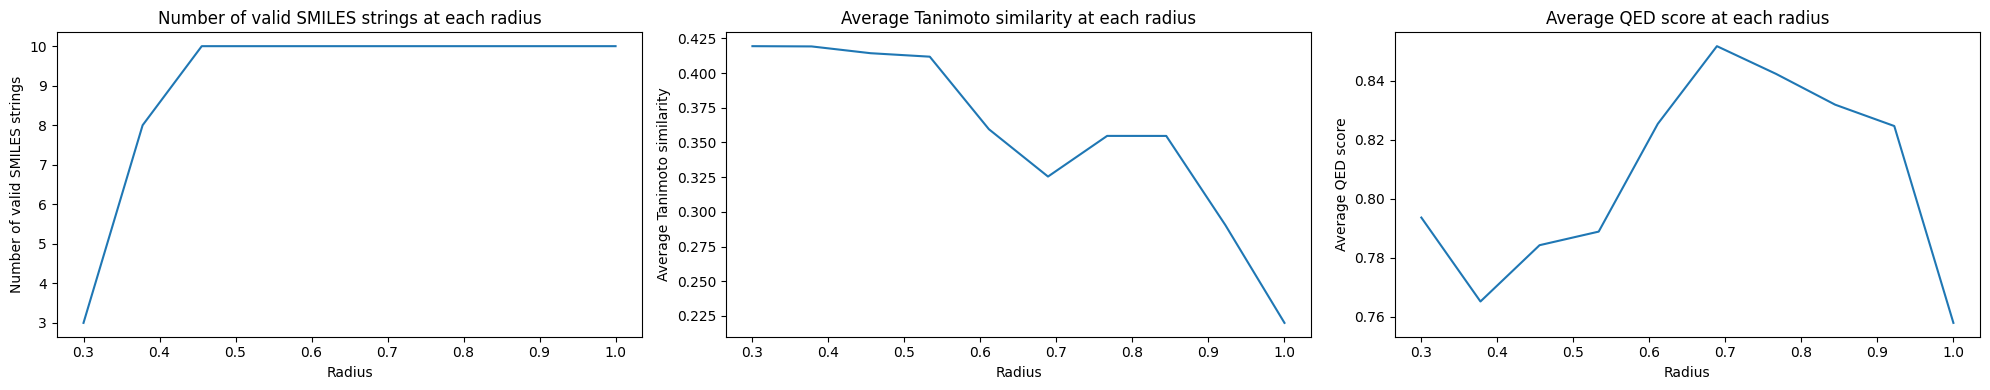

In [6]:
# Create the plots
plt.figure(figsize=(20, 4))

# Plot the number of valid SMILES strings at each radius
plt.subplot(1, 3, 1)
plt.plot(df['index'], df['valid_smiles'])
plt.xlabel('Radius')
plt.ylabel('Number of valid SMILES strings')
plt.title('Number of valid SMILES strings at each radius')

# Plot the average Tanimoto similarity at each radius
plt.subplot(1, 3, 2)
plt.plot(df['index'], df['tanimoto_similarity'])
plt.xlabel('Radius')
plt.ylabel('Average Tanimoto similarity')
plt.title('Average Tanimoto similarity at each radius')

# Plot the average QED score at each radius
plt.subplot(1, 3, 3)
plt.plot(df['index'], df['qed_score'])
plt.xlabel('Radius')
plt.ylabel('Average QED score')
plt.title('Average QED score at each radius')

plt.tight_layout()
plt.show()

## Guided Molecular Generation with CMA-ES

In contrast to the random sampling of the latent space described above, we can use a black box optimizer, called CMA-ES, to perform guided optimization of the a molecule's property through sampling of the latent space. In the blocks below, we use CMA-ES to optimize the QED score of the generated molecules while preseving a level of similary to the seed molecule, upadacitinib.

This first block initializes variables to store the results of the script and sets up the parameters for the experiment. It defines three lists to store the counts of valid SMILES strings, average Tanimoto similarities, and average QED scores. It also creates an empty dictionary to store the results and a list of minimum similarities to be used in the experiment, ranging from 0.1 to 0.7 with 10 evenly spaced values.

In [7]:
# Initialize lists to store the results
valid_smiles_counts = []
avg_tanimoto_similarities = []
avg_qed_scores = []

# Create a dictionary to store the results
results = {}

# Create a list of minimum similarities
min_sims = np.linspace(0.1, 0.7, 10)

The following block is the main loop of the script, where it iterates over each minimum similarity value in the `min_sims` list. For each minimum similarity, it generates molecules using the CMA-ES algorithm, filters out invalid SMILES strings, calculates the Tanimoto similarity and QED score for each valid SMILES string, and stores the results. The results are stored in a dictionary called `results`, where the keys are the minimum similarity values and the values are dictionaries containing the number of valid SMILES strings, average Tanimoto similarity, and average QED score. After the loop, the results are converted into a Pandas dataframe for further analysis.

In [8]:
# Loop through each radius
for min_sim in min_sims:
    # Create a dictionary to store the results for this min_sim
    min_sim_results = {'tanimoto_similarity': [], 'qed_score': []}
    
    # Create the request data
    data = {
        'smi': upadacitinib,
        'algorithm': 'CMA-ES',
        'num_molecules': 10,
        'property_name': 'QED',
        'minimize': False,
        'min_similarity': min_sim,
        'particles': 20,
        'iterations': 3
    }

    # Send the request and get the response
    headers = {'Content-Type': 'application/json'}
    response = requests.post('http://localhost:8000/generate', headers=headers, json=data)

    # Parse the response as JSON
    response_json = json.loads(response.text)

    # Extract the generated SMILES strings
    generated_molecules = [i['smiles'] for i in response_json['generated']]

    # Filter out invalid SMILES strings
    valid_smiles = [m for m in generated_molecules if Chem.MolFromSmiles(m) is not None]
    min_sim_results['valid_smiles'] = len(valid_smiles)
    
    # Calculate Tanimoto similarity and QED score for each valid SMILES string
    for smile in valid_smiles:
        mol = Chem.MolFromSmiles(smile)
        if mol:
            tanimoto = tanimoto_similarity(smile, upadacitinib)
            qed_score = qed(mol)
            min_sim_results['tanimoto_similarity'].append(tanimoto)
            min_sim_results['qed_score'].append(qed_score)

    # Get the average of Tanimoto and QED scores
    min_sim_results['tanimoto_similarity'] = np.mean(min_sim_results['tanimoto_similarity'])
    min_sim_results['qed_score'] = np.mean(min_sim_results['qed_score'])
    
    # Store the results for this min_sim
    results[min_sim] = min_sim_results

# Create a Pandas dataframe from the results
df = pd.DataFrame(results).T.reset_index()

The following block creates three plots to visualize the results of the script. The first plot shows the number of valid SMILES strings generated at each minimum similarity threshold. The second plot shows the average Tanimoto similarity of the generated molecules at each minimum similarity threshold. The third plot shows the average QED score of the generated molecules at each minimum similarity threshold. The plots are arranged in a single figure with three subplots, and the figure is displayed using the `plt.show()` function.

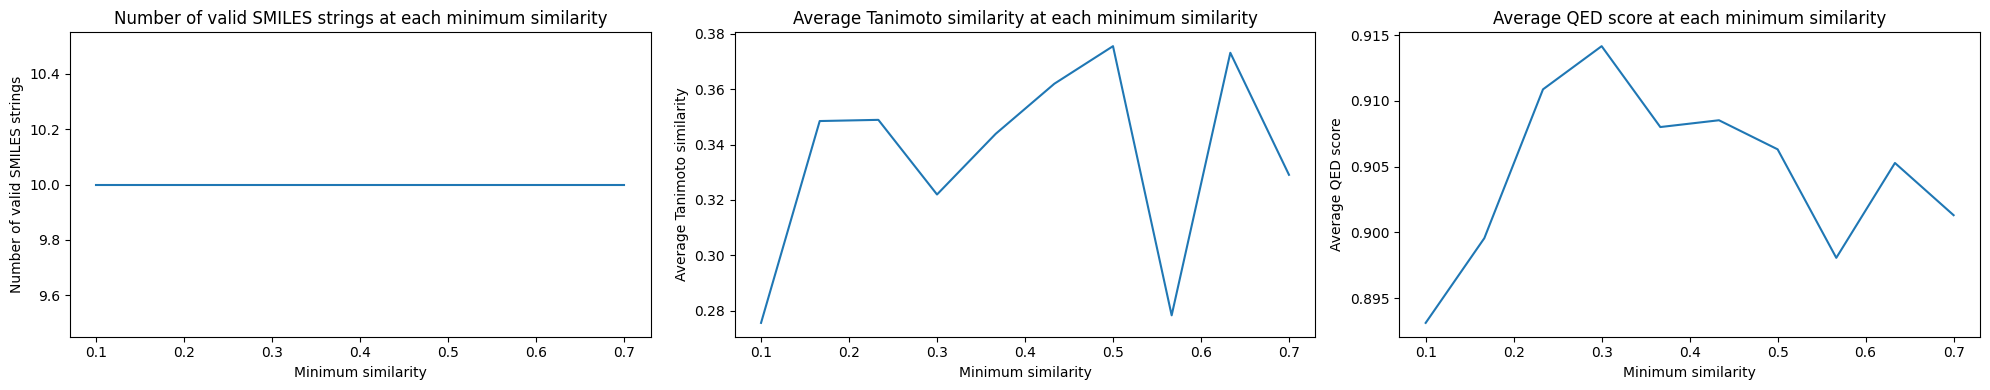

In [9]:
# Create the plots
plt.figure(figsize=(20, 4))

# Plot the number of valid SMILES strings at each min_sim
plt.subplot(1, 3, 1)
plt.plot(df['index'], df['valid_smiles'])
plt.xlabel('Minimum similarity')
plt.ylabel('Number of valid SMILES strings')
plt.title('Number of valid SMILES strings at each minimum similarity')

# Plot the average Tanimoto similarity at each radius
plt.subplot(1, 3, 2)
plt.plot(df['index'], df['tanimoto_similarity'])
plt.xlabel('Minimum similarity')
plt.ylabel('Average Tanimoto similarity')
plt.title('Average Tanimoto similarity at each minimum similarity')

# Plot the average QED score at each radius
plt.subplot(1, 3, 3)
plt.plot(df['index'], df['qed_score'])
plt.xlabel('Minimum similarity')
plt.ylabel('Average QED score')
plt.title('Average QED score at each minimum similarity')

plt.tight_layout()
plt.show()

Note that the `min_similarity` parameter is not a hard cutoff, but rather the minimum similarity necessary to receive a full score for the Tanimoto similarity component of the scoring function. Generally the average similarity will increase with increasing `minimum_similarity` thresholds, but the similarity of the generated molecules to the seed is not guaranted to exceed that threshold.